In [1]:
import logging
logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')



# Config

In [2]:
TRAIN = False
TRAIN_MODEL_3 = False

TRAIN_TEST_SPLIT_SEED = 49
TEST_SIZE = 0.08
TRAIN_FROM_CP = True  

# CP===check point

EPOCHS = 120
LR = 5.000e-6

#learning rate

TEST_FLOW = False
DEBUG = False


# CHECKPOINT_URL = 'runs:/89d43de209874227af95fcbeaf048340/model'
CHECKPOINT_URL = None

In [3]:
import sys

IN_COLAB = 'google.colab' in sys.modules

print (f'Running in colab: {IN_COLAB=}')
print (f'{TRAIN_FROM_CP=}')
print (f'{LR=}')
print (f'{EPOCHS=}')
print (f'{TRAIN=}')
print (f'{DEBUG=}')
print (f'{CHECKPOINT_URL=}')

Running in colab: IN_COLAB=False
TRAIN_FROM_CP=True
LR=5e-06
EPOCHS=120
TRAIN=False
DEBUG=False
CHECKPOINT_URL=None


In [4]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

In [5]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

In [6]:
import os
import random
import math
import json
import warnings

from os import path
from pathlib import Path
import analyser.hyperparams


if not IN_COLAB:
    _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
    work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

    if not os.path.isdir(work_dir):
        os.mkdir(work_dir)

    analyser.hyperparams.work_dir = work_dir
else:

    from google.colab import drive
    drive.mount('/content/drive')
    os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
    analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

    
    
work_dir = Path(analyser.hyperparams.work_dir)
training_reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'
NOTEBOOKS_DIR = str(Path(analyser.__file__).parent.parent/'trainsets')

print(f'{analyser.hyperparams.work_dir=}')
print(f'{training_reports_path=}')
print(f'{work_dir=}')

assert os.path.isdir(analyser.hyperparams.work_dir)

Nemoware Analyser v23.3.15
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]
analyser.hyperparams.work_dir='/root/artem/work'
training_reports_path=PosixPath('/root/artem/analyser/training_reports')
work_dir=PosixPath('/root/artem/work')


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


# Imports

In [7]:
%matplotlib inline
import tensorflow as tf
print(f'{tf.__version__=}')



import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *

import pickle
import numpy as np
import pandas as pd

 
import random
 

from bson import json_util

from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector, get_tokens_features
from analyser.hyperparams import models_path
from analyser.text_tools import find_top_spans
from analyser.persistence import DbJsonDoc

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from tf_support import super_contract_model
from tf_support.super_contract_model import get_base_model, semantic_map_keys_contract
from tf_support.super_contract_model import uber_detection_model_005_1_1
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.tools import KerasTrainingContext
# from tf_support.embedder_elmo import ElmoEmbedder


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
 
from keras.models import load_model


from tensorflow import keras
import keras.backend as K
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model

# from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences


2023-03-15 15:10:23.723010: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


tf.__version__='2.5.0'


/tmp/ipykernel_2349314/818500624.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


# Init mlflow

In [8]:
import mlflow


ml_flow_url = os.environ.get('MLFLOW_URL', "http://192.168.10.38:5000")
mlflow.set_tracking_uri(ml_flow_url)
print(f'{ml_flow_url=}', 'set MLFLOW_URL env var to re-define')
mlflow.set_experiment("Обучение анализатора")

mlflow.tensorflow.autolog()

ml_flow_url='http://192.168.10.38:5000' set MLFLOW_URL env var to re-define


In [9]:
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')

# for device in gpu_devices:
#     print(device)
#     tf.config.experimental.set_memory_growth(device, True)

# Prepare trainset


In [10]:
if not IN_COLAB:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata = documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

In [11]:
if DEBUG:
    jdoc = get_doc('5df1f44dec85d861954efc47')
    doc = jdoc.asLegalDoc()
    doc.tokens
    

In [12]:
umtm = UberModelTrainsetManager (work_dir, reports_dir=training_reports_path)

umtm.load_contract_trainset_meta() # 'contract_trainset_meta.csv'
stats = umtm.stats
if DEBUG:
    stats

In [13]:
# stats[ ['org-1-alias', 'org-2-alias'] ]

user_dataset = stats[ stats['unseen']==False]

print(f'{len(user_dataset)=}')
print(f'{len(stats)=}')


mlflow.log_param('dataset_len_user', len(user_dataset) )
mlflow.log_param('dataset_len', len(stats) )

len(user_dataset)=1253
len(stats)=2077


2077

In [14]:
if DEBUG:
    user_dataset[user_dataset.subj_len>=150]

# Weights: вычисление весов samples  

чтобы всех запутать, 
 - вес пропорционален логорифму цены контракта (чтобы было меньше ошибок в контрактах на большие суммы)
 - more weight for user-corrected datapoints
 - normalize weights, so the sum == Number of samples

In [15]:
errors_file = training_reports_path / 'user_markup_errors.csv'
print(f'{errors_file=}')
errors_df = pd.read_csv(errors_file, index_col=0)
if DEBUG:
    errors_df

errors_file=PosixPath('/root/artem/analyser/training_reports/user_markup_errors.csv')


In [16]:
from trainsets.trainset_tools import get_feature_log_weights
stats = umtm.stats
stats = stats[stats.documentType != 'ANNEX']
stats = stats[stats.documentType != 'undefined']

print(len(stats))
get_feature_log_weights(stats, 'documentType')

# stats.sort_values(['Дата']) 

if DEBUG:
    stats

2077


In [17]:
# from trainsets.trainset_tools import get_feature_log_weights
# _w=get_feature_log_weights(umtm.stats, 'subject')
# _w*_w*_w

In [18]:
%%time

import datetime

subject_weights = get_feature_log_weights(stats, 'subject')
subject_weights = subject_weights * subject_weights * subject_weights

for i, row in stats.iterrows():
  subj_name = row['subject']

  #error weight
  error_weight = 1.0 
  if i in errors_df.index:
      error_weight = 1.0 + errors_df.at[i, 'errors severity']


  sample_weight = 0.5 
  value_weight = 1.0
    
  if i in errors_df.index:
       
      if type(errors_df.at[i, 'Дата'])==str:
#             print (errors_df.at[i, 'Дата'], i, 'EXISTS')
          value_weight *=1.5
    
  if not pd.isna(row['user_correction_date']):  # more weight for user-corrected datapoints
    sample_weight = 5.0   # TODO: must be estimated anyhow smartly    

  
  if not pd.isna(row['value_log1p']):
    # чтобы всех запутать, вес пропорционален логорифму цены контракта
    # (чтобы было меньше ошибок в контрактах на большие суммы)
    value_weight = 1.0 + row['value_log1p']

  sample_weight *=  value_weight 
  subject_weight =  subject_weights[subj_name] 
    
  sample_weight /= error_weight  

  stats.at[i, 'subject_weight'] = subject_weight + random.random()*0.05
  stats.at[i, 'sample_weight'] = sample_weight + random.random()*0.05

# normalize weights, so the sum == Number of samples
# stats.sample_weight /= stats.sample_weight.mean()
# stats.subject_weight /= stats.subject_weight.mean()

print(f'{stats.sample_weight.mean()=}')
print(f'{stats.subject_weight.mean()=}')
print(f'{stats.sample_weight.min()=}')
print(f'{stats.subject_weight.min()=}')
print(f'{stats.sample_weight.max()=}')
print(f'{stats.subject_weight.max()=}')

stats.to_csv( work_dir / 'contract_trainset_meta.csv', index=True)

# stats

stats.sample_weight.mean()=21.255336273311897
stats.subject_weight.mean()=0.34825254057444066
stats.sample_weight.min()=0.33678311121431714
stats.subject_weight.min()=0.1163902860942541
stats.sample_weight.max()=131.68812568761797
stats.subject_weight.max()=5.563560063016419
CPU times: user 210 ms, sys: 3.2 ms, total: 213 ms
Wall time: 216 ms


In [19]:
from tf_support.super_contract_model import make_xyw


# Validating training set

In [20]:
%%time


from tf_support.super_contract_model import  validate_datapoint

# stats['valid'] = True
stats['error'] = ''

 
for i in stats.index:

  try:
    validate_datapoint(str(i), stats)

  except Exception as e:
    logger.error(e)

    stats.at[i, 'valid'] = False
    stats.at[i, 'error'] = str(e)
    
# stats

 

umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS
stats_valid = stats[stats['valid']]

del stats
print(len(stats_valid))
stats = stats_valid
umtm.stats = stats_valid

ERROR - 2023-03-15 15:10:32,298 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5f9672f282451803b5001dfd-datapoint-embeddings.npy'
ERROR - 2023-03-15 15:10:33,097 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fbbbd1ba2b4551c061079fe-datapoint-embeddings.npy'
ERROR - 2023-03-15 15:10:35,070 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fb3d4a078df3635f5441c56-datapoint-embeddings.npy'


2074
CPU times: user 1.62 s, sys: 6.65 s, total: 8.27 s
Wall time: 13.1 s


/root/artem/env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [21]:
print(f'{stats.sample_weight.mean()=}')
print(f'{stats.subject_weight.mean()=}')

stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()



stats.sample_weight.mean()=21.27692795891389
stats.subject_weight.mean()=0.3483810032702178


In [22]:
print(f'{stats.sample_weight.mean()=}')
print(f'{stats.subject_weight.mean()=}')

print('\n\nsample_weight')
print('MIN\t', stats.sample_weight.min())
print('MAX\t', stats.sample_weight.max())
print('MEAN\t', stats.sample_weight.mean())

stats.sample_weight.mean()=1.0000000000000002
stats.subject_weight.mean()=1.0


sample_weight
MIN	 0.015828559078860025
MAX	 6.1892452680156635
MEAN	 1.0000000000000002


/root/artem/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


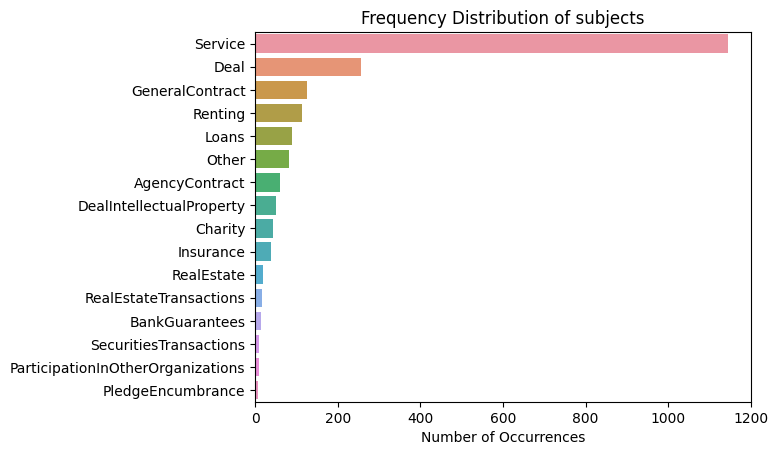


min 6
max 1144
total 2074


In [23]:
%matplotlib inline

subj_count = stats_valid['subject'].value_counts()

#plot distribution---------------------
fig=plt.figure()
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
# plt.show()

# XXXX

plt.savefig( training_reports_path / 'Distribution of subjects.png', bbox_inches='tight', pad_inches=0)
plt.show()

mlflow.log_artifact(training_reports_path / 'Distribution of subjects.png')



# mlflow.log_figure(fig, 'Distribution of subjects.png')

print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [24]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = stats_valid['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(stats_valid, 'subject')
class_weights

classes: ['AgencyContract', 'Service', 'BankGuarantees', 'Charity', 'Loans', 'ParticipationInOtherOrganizations', 'RealEstateTransactions', 'PledgeEncumbrance', 'DealIntellectualProperty', 'SecuritiesTransactions', 'Renting', 'Deal', 'RealEstate', 'Insurance', 'GeneralContract', 'Other']


Service                              0.488083
Deal                                 0.619066
GeneralContract                      0.710804
Renting                              0.725824
Loans                                0.763954
Other                                0.775850
AgencyContract                       0.839609
DealIntellectualProperty             0.874314
Charity                              0.913977
Insurance                            0.931895
RealEstate                           1.147515
RealEstateTransactions               1.213339
BankGuarantees                       1.302605
SecuritiesTransactions               1.433611
ParticipationInOtherOrganizations    1.492952
PledgeEncumbrance                    1.766602
Name: subject, dtype: float64

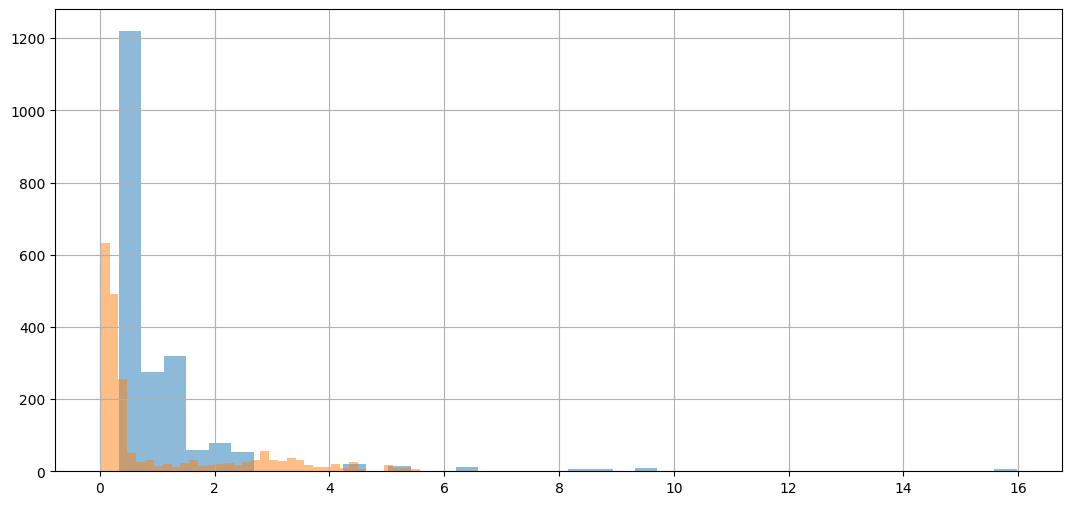

In [25]:
from trainsets.trainset_tools import get_feature_log_weights
 

fig = plt.figure(figsize=(13, 6))

stats_valid['subject_weight'].hist(bins=40, alpha=0.5)
stats_valid['sample_weight'].hist(bins=40, alpha=0.5)

plt.xscale('linear') # log?
plt.show()
mlflow.log_figure(fig, 'Weights Distribution.png')

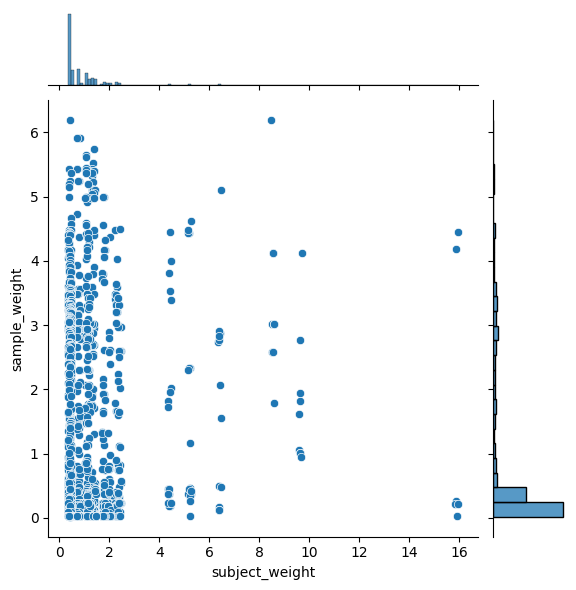

In [26]:
# fig = plt.figure(figsize=(13, 6))

p = sns.jointplot(x="subject_weight", y="sample_weight", data=stats_valid)
plt.show()
# print(p)

# look into trainset (take a sample)

In [27]:
%matplotlib inline
# umtm.calculate_samples_weights()
 
if DEBUG:   
    SAMPLE_DOC_ID =  stats_valid.index[2]

    print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
    (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = make_xyw(SAMPLE_DOC_ID, stats)


    print('semantic map shape is:', sm.shape)
    _crop = 500
    # plot_embedding(tok_f[:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
    # plot_embedding(emb[:_crop], title=f'Embedding {SAMPLE_DOC_ID}') 
    plot_embedding(sm[:_crop], title=f'Semantic map {SAMPLE_DOC_ID}')



In [28]:

if DEBUG:   
    plot_embedding(sm[:, 1::2][:200], title=f'Semantic map {SAMPLE_DOC_ID}')

In [29]:
if DEBUG:   
    nonzerozz = np.where(sm[:, 1::2] > 0)[0]
    max_len = 1536
    # nonzerozz = list(set(nonzerozz))
    # nonzerozz

    # c=random.choice(nonzerozz)
    # sm[c-1:c]
    sm = sm*100.
    for i in range(0,2000):
        segment_center = random.choice(nonzerozz)

        _off = random.randint(-max_len//40, max_len//2)
        start_from = segment_center - _off
        if start_from < 0:
            start_from = 0
        if start_from >=len(emb):
            start_from = len(emb)-1

        sm[start_from: start_from+max_len]+=1

    plot_embedding(sm, title=f'Semantic map {SAMPLE_DOC_ID}')


In [30]:
# # sm[1].argmax()
# for i in range(0,10):
#     print(random.random() < 0.8)
# #     random_row = random.randint(0, sm.shape[-1])
# #     focus_pos = sm[random_row].argmax()
# #     print(random_row, focus_pos, sm[random_row][focus_pos])

# Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq
- [ ] TODO: introduce individual per tag threshosholds, also, the current 0.3 threshold is strange.

semantic map shape is: (10, 647, 30)


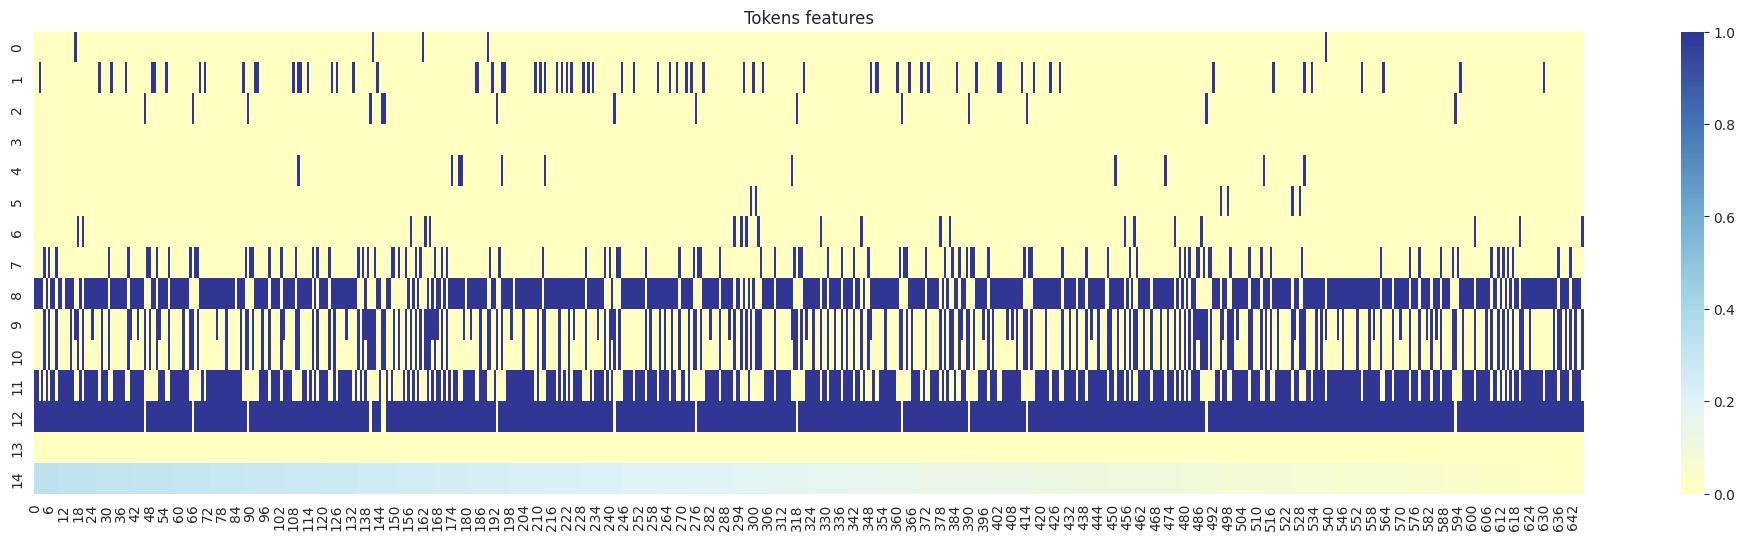

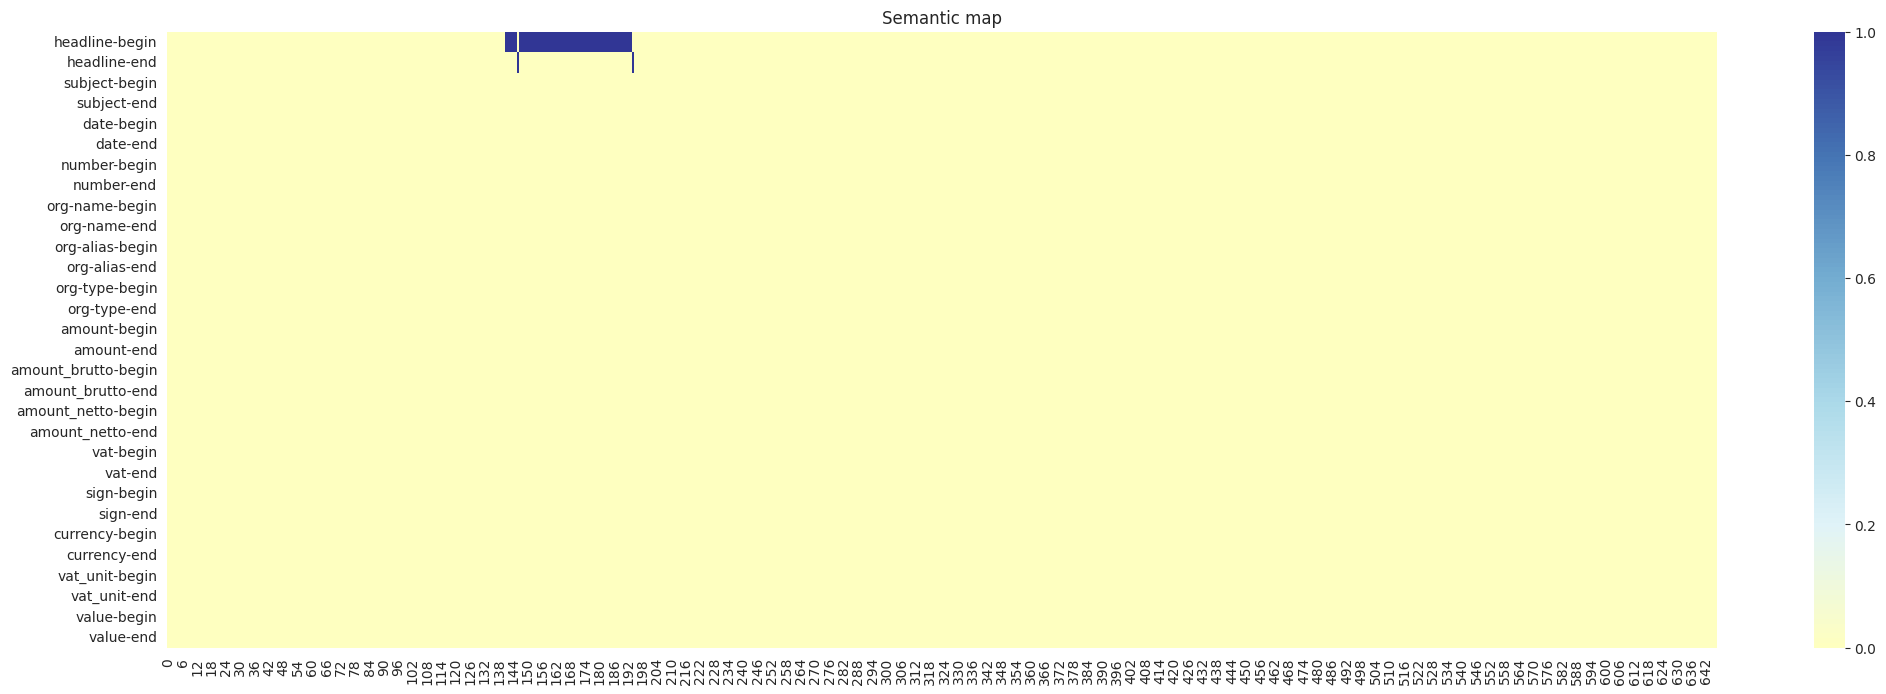

In [31]:


MAX_LEN = 1536
def make_generator(self, indices: [int], batch_size: int, augment_samples=False):
  #   np.random.seed(43)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = MAX_LEN
    start_from = 0

    if augment_samples:
      max_len = random.randint(300, MAX_LEN)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = make_xyw(doc_id, stats)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

      #       print(dp)

      subject_weight_K = 1.0
      if augment_samples:
        start_from = 0

        # row = stats_valid.loc[doc_id]
        if random.random() < 0.6:  # 60% of samples
          nonzerozz = np.where(sm[:, 1::2] > 0)[0] #take every second row, because these are end marks
#           nonzerozz = nonzerozz
          
          segment_center = random.choice(nonzerozz)
          if len(nonzerozz)==0:
             segment_center=0


          # segment_center = random.randint(0, len(emb) - 1)  ##select random token as a center

          # if not pd.isna(row['value_span']) and random.random() < 0.7:  ##select value token as a center
          #   segment_center = int(row['value_span'])

          # _off = random.randint(max_len // 4, max_len // 2)
          _off = random.randint(-max_len//10, max_len//2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          if start_from >=len(emb):
            start_from = len(emb)-1
#           print('start_from', start_from)
#           if random_row != 1:#subject row, see semantic_map_keys
#               subject_weight_K = 0.1  # lower subject weight because there mighе be no information about subject around doc. value

      dp = self.trim_maxlen(dp, start_from, max_len)

      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
      #       print((sample_weight, subject_weight))
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      if np.isnan(sample_weight):
        raise ValueError()

      if np.isnan(subject_weight):
        raise ValueError()

      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Returns a tuple of (input, output, weights) to feed the network
    #     print('batch_output_subj', len(batch_output_subj))
    #     print('batch_output_sm', len(batch_output_subj))

    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
           [np.array(batch_output_sm), np.array(batch_output_subj)],
           [np.array(weights), np.array(weights_subj)])
    

    
_train, _test = train_test_split(stats_valid, test_size=TEST_SIZE, stratify=stats_valid[['subject']], random_state=TRAIN_TEST_SPLIT_SEED)

train_indices = list(_train.index)
test_indices = list(_test.index)

    
####---test
_gen = make_generator(umtm, train_indices, batch_size=10, augment_samples=True)

sample = next(_gen)
# print(len(sample))
del _gen
 
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = sample
    
print('semantic map shape is:', sm.shape)
_crop = 1500
_ = plot_embedding(tok_f[0][:_crop], title=f'Tokens features') 
# plot_embedding(emb[:_crop],   title=f'Embedding {SAMPLE_DOC_ID}') 
_ = plot_embedding(pd.DataFrame( sm[0], columns= semantic_map_keys_contract) [:_crop],    title=f'Semantic map', height=8)

## Diagnose SM Rows in TS

In [32]:
# plot_embedding(pd.DataFrame( sm[0], columns= semantic_map_keys_contract) [:_crop],    title=f'Semantic map', height=8)
if DEBUG:
    _crop = 350
    batch_size=100
    mtx = np.zeros((batch_size, _crop))


    _gen = make_generator(umtm, train_indices, batch_size=batch_size, augment_samples=True) 

 


    for i in range(0, batch_size):

        sample = next(_gen)
        (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = sample


        sub = sm[0][:,4:6][:_crop] #pd.DataFrame( sm[0], columns= semantic_map_keys_contract) [:_crop][['date-begin']]

    #     print(sub[:,0].max())
        mtx [i][0:len(sub[:,0])] = sub[:,0]

    fig = plot_embedding(mtx.T,    title=f'Semantic map, combined Date rows of {batch_size} samples', height=5)
    mlflow.log_figure(fig, 'Diagnose SM Rows in TS.png')
    del _gen
    del mtx

In [33]:
mlflow.log_param('dataset_len_train', len(train_indices) )
mlflow.log_param('dataset_len_test', len(test_indices) )

166

In [34]:
if DEBUG:
    dp = make_xyw(stats.index[0], stats_valid)

    (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

    fig = plot_embedding(sm[:500],    title=f'Semantic map ')

train_indices[0]: 5efe924a777d4b67a92d558c
test_indices[0]: 5fe34f64b770574a005553e2


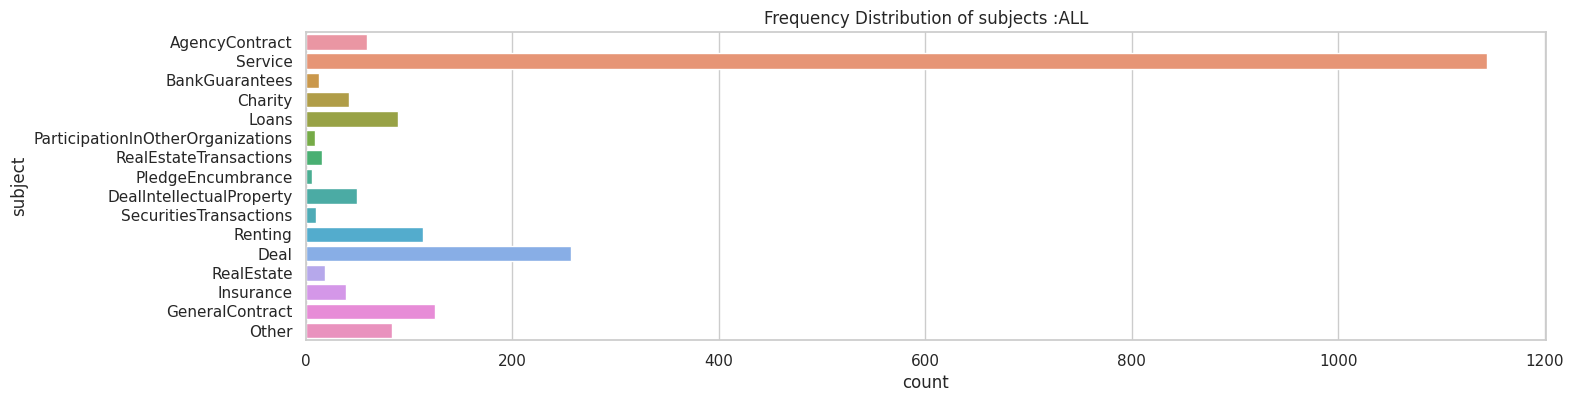

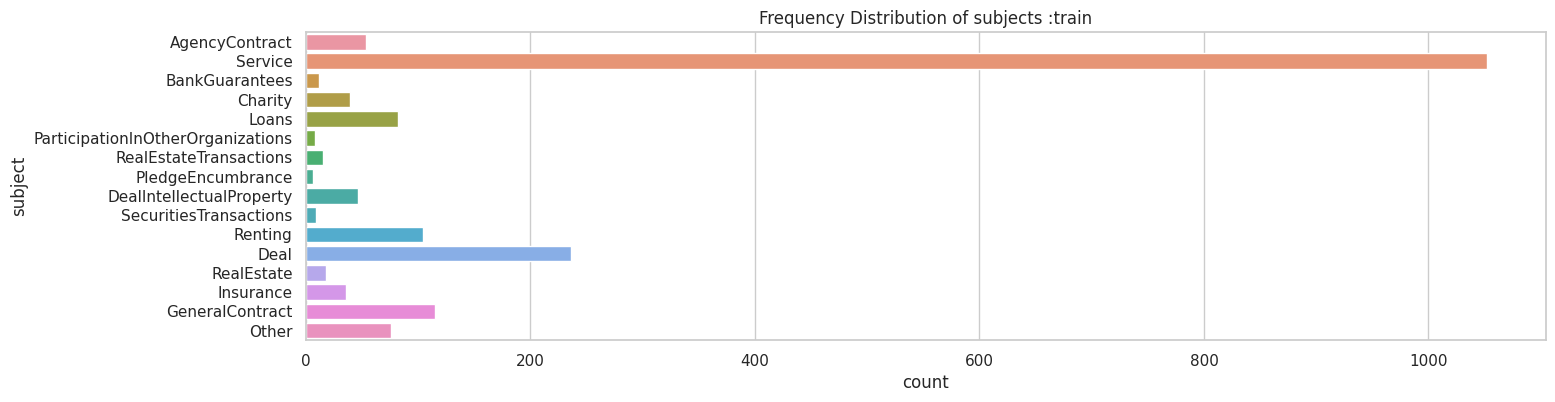

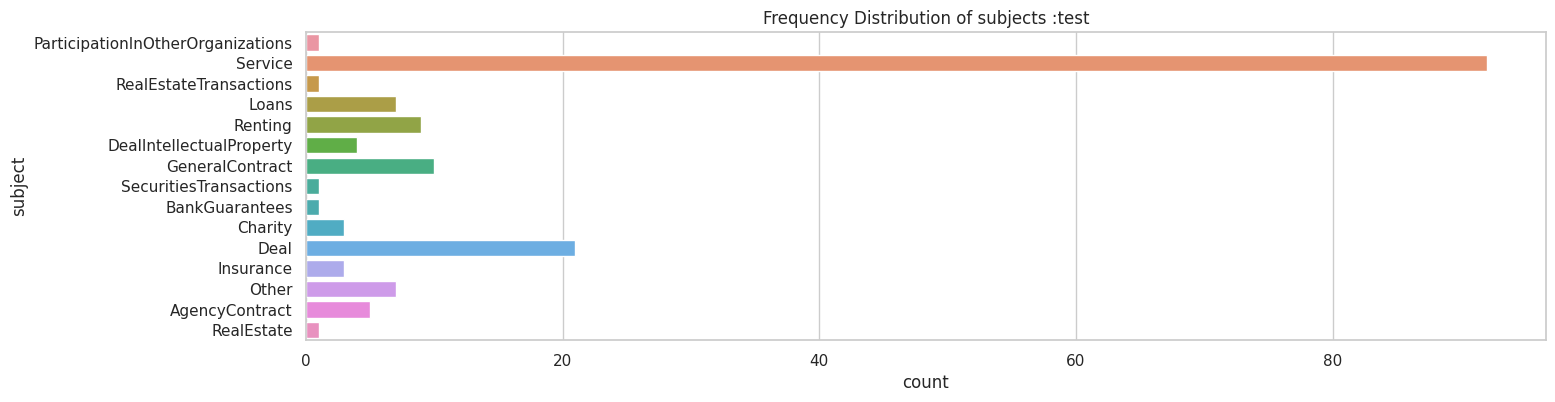

In [35]:

BATCH_SIZE = 72
EMB =  1024
 


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  fig = plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  t = f'Frequency Distribution of subjects :{title}'
  plt.title(t)
  # mlflow.log_figure(fig, f'{t}.png')

  plt.savefig( training_reports_path / f'{t}.png', bbox_inches='tight', pad_inches=0)
  plt.show()

  mlflow.log_artifact(training_reports_path / f'{t}.png')


 
plot_subject_distr(stats_valid, 'ALL')
plot_subject_distr(stats_valid[stats_valid.index.isin(train_indices)], 'train')
plot_subject_distr(stats_valid[stats_valid.index.isin(test_indices)], 'test')



if DEBUG:   
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
#   print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
#   print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

#   plot_embedding(x[0][0], 'X2: Token Embeddings')
#   plot_embedding(x[1][0], 'X1: Token Features')
#   plot_embedding(y[0][0], 'Y: Semantic Map')
  
#   print(y[0][1])

#   del x
#   del w
#   del y
#   del train_gen

In [36]:

ctx = KerasTrainingContext(checkpoints_path=umtm.reports_dir, session_index=1)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']


def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/training_reports


batch_size:	72
train_samples:	7632
test_samples:	166
steps_per_epoch:	106
validation_steps:	53


# Models 🦖

In [37]:
def get_weights_filename(model_factory_fn):
    weights = ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.h5'
    print(weights.is_file(), weights)
    if not weights.is_file():
        weights = Path(analyser.hyperparams.models_path) / f'{model_factory_fn.__name__}.h5'
        print(weights.is_file(), weights)
    
    return weights

# get_weights_filename(uber_detection_model_005_1_1)

In [38]:
from tf_support.super_contract_model import FEATURES 
from analyser.headers_detector import TOKEN_FEATURES

from tf_support.super_contract_model import sigmoid_focal_crossentropy, losses

import numpy as np
from pandas import DataFrame 


## 🥰 Att model

In [39]:
from tf_support.tools import KerasTrainingContext
from tf_support.super_contract_model import config, make_att_model

model_factory_fn = make_att_model      
# TRAIN_FROM_CP = True
if TRAIN_FROM_CP:
    weights = get_weights_filename(model_factory_fn)
else:
    weights = Path(analyser.hyperparams.models_path) / f'{model_factory_fn.__name__}.h5'
    
# weights = Path(analyser.hyperparams.models_path) / f'{model_factory_fn.__name__}.h5'


# TRAIN_FROM_CP=True        
if not TEST_FLOW:
    
    umodel = make_att_model() 
    print(f'{umodel.name=}')    

    if CHECKPOINT_URL is not None:
        logger.info(f'LOADING {CHECKPOINT_URL}')
        umodel = mlflow.tensorflow.load_model(CHECKPOINT_URL)
    else:
        if TRAIN_FROM_CP:
            logger.info(f'LOADING {weights}')
            print(f'LOADING {weights=}')
            umodel.load_weights(weights, by_name=True, skip_mismatch=True)
        else:
            logger.warning(f'skip loading weights, because {TRAIN_FROM_CP=}')

    # if DEBUG:    
    umodel.summary()

# raise "forsibly stopped"


2023-03-15 15:10:46.647900: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-03-15 15:10:46.669643: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 15:10:46.669863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-03-15 15:10:46.669877: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-03-15 15:10:46.669915: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-15 15:10:46.669932: I tensorflow/stream_executor/platform/defa

True /root/artem/analyser/training_reports/make_att_model_03.h5


/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2023-03-15 15:10:46.670584: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcurand.so.10
2023-03-15 15:10:46.671007: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcusolver.so.11
2023-03-15 15:10:46.671358: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcusparse.so.11
2023-03-15 15:10:46.671384: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-03-15 15:10:46.671426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 15:10:46.671606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS

umodel.name='make_att_model_03'
LOADING weights=PosixPath('/root/artem/analyser/training_reports/make_att_model_03.h5')
Model: "make_att_model_03"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
token_features (InputLayer)     [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
input_text_emb_norm (LayerNorma (None, None, 1024)   2048        input_text_emb[0][0]             
__________________________________________________________________________________________________
token_features_norm (LayerNorma (None, None, 15)     30      

In [41]:
# dot_img_file = f'{umodel.name}.png'
# keras.utils.plot_model(umodel, to_file=dot_img_file, show_shapes=True)



In [ ]:
def train_and_evaluate_model(self, model:Model, generator, test_generator, retrain=False, lr=None):
    print(f'model.name == {model.name}')
    self.trained_models[model.name] = model.name
    if self.EVALUATE_ONLY:
      print(f'training skipped EVALUATE_ONLY = {self.EVALUATE_ONLY}')
      return

    _log_fn = f'{model.name}.{self.session_index}.log.csv'
    _logger1 = CSVLogger(self.model_checkpoint_path / _log_fn, separator=',', append=not retrain)
    _logger2 = CSVLogger(_log_fn, separator=',', append=not retrain)

    checkpoint_weights = ModelCheckpoint(self.model_checkpoint_path / (model.name + ".h5"),
                                         monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True,
                                         verbose=1)

    lr_logged = None
    if not retrain:
      lr_logged, epoch = self.get_lr_epoch_from_log(model.name)
    else:
      epoch = 0

    if lr_logged is not None:
      K.set_value(model.optimizer.lr, lr_logged)

    if lr is not None:
      K.set_value(model.optimizer.lr, lr)

    print(f'continue: lr:{K.get_value(model.optimizer.lr)}, epoch:{epoch}')


    history = model.fit(
                    generator, batch_size=BATCH_SIZE,
#                     steps_per_epoch=train_steps,
                    epochs=self.EPOCHS,
                    validation_data=test_generator,
                    validation_steps=self.validation_steps,
                    steps_per_epoch=self.steps_per_epoch,
#                     class_weight=class_weights,
                    initial_epoch=epoch, 
#                     workers=8,
                    callbacks=[self.reduce_lr, checkpoint_weights, _logger2, _logger1]
                    )
    
    

    self.HISTORIES[model.name] = history
    self.save_stats(model.name)

    return history


if not TEST_FLOW:

    if TRAIN:
      config.LR = LR
      ctx.unfreezeModel(umodel)
    #   umodel.summary()

      ctx.EPOCHS = EPOCHS
      ctx.EVALUATE_ONLY = False

      BATCH_SIZE = 96
      test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 

      train_and_evaluate_model(ctx, umodel, train_gen, test_generator=test_gen, retrain=True, lr=config.LR)
    else:
      logger.warning(f'skip training, because TRAIN={TRAIN}')


    threshold = umodel.get_layer('O1_tagging').get_weights()
    if threshold:
        print('threshold=', threshold[0][0])

        mlflow.log_metric('trained_tags_threshold', threshold[0][0])

In [42]:
mlflow.log_artifact(ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.h5')

# Evaluate last checkpoint

In [ ]:
if not TEST_FLOW:
    if umodel:
        del umodel

    #######################################
    #######################################
    model_fn = make_att_model
    # model_fn = uber_detection_model_003
    #######################################
    #######################################


    weights = ctx.model_checkpoint_path /  f'{model_factory_fn.__name__}.h5'
    logger.info(f'LOADING {weights}')
    print(f'LOADING {weights}')

    umodel = make_att_model() 
    umodel.load_weights(weights, by_name=False, skip_mismatch=False)
    umodel.trainable = False
    umodel.summary()

    # umodel = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_fn.__name__}.h5')



    #TODO: remove next 2 lines
    ctx.trained_models[umodel.name] = umodel.name
    models = ctx.trained_models

### training history

In [ ]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.reports_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid(True)
        plt.title(f'{metric} [{m}]')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{[m]} {title}')
        plt.grid(True)
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        
        plt.savefig(img_path, bbox_inches='tight')        
        plt.show()
    else:
      logger.error('cannot plot')
    
if not TEST_FLOW:
    models = list(ctx.trained_models.keys())


    plot_compare_models(models, ['loss'], 'Loss')

    # plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
    # plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
    # plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
    # plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

    plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')


In [ ]:
from tf_support.super_contract_model import make_xyw
logger.error("fix prediction!!")
if False:
    sample_index = umtm.stats [umtm.stats['value']>0].index[2]
    logger.info(f'making prediction for sample doc {sample_index}')

    x, y, _ = make_xyw(sample_index, umtm.stats)
    print(f'shape of x[0]={x[0].shape}')
    print(f'shape of x[1]={x[1].shape}')

    t1 = np.expand_dims(x[0], axis=0)
    t2 = np.expand_dims(x[1], axis=0)

    print(f'shape of t1={t1.shape}')
    print(f'shape of t2={t2.shape}')
    print(f'umodel.name ={umodel.name}')

    prediction = umodel.predict(x=[t1, t2], batch_size=1)

    tagsmap = pd.DataFrame(prediction[0][0], columns=semantic_map_keys_contract)
    # .T
    plot_embedding(tagsmap[:500], f'Predicted Semantic Map {tagsmap.shape}')

# Evaluate recent model (with external notebook)

In [ ]:
if not TEST_FLOW:
    %run -i -t {NOTEBOOKS_DIR}/eval_contract_uber_model.ipynb
 

In [ ]:
print('see results at')
print(f'{mlflow.get_registry_uri()}/#/experiments/{mlflow.last_active_run().info.experiment_id}/runs/{mlflow.last_active_run().info.run_id}')